In [1]:
import os
os.getcwd()

'/mnt/ailon/pdb_test/1109'

dataset: data_pdb
GNNNet Loaded
dataset: data_pdb
test entries: 77 effective test entries 77
effective drugs,effective prot: 77 77
Make prediction for 77 samples...
metrics for  data_pdb
cindex: 0.49744897959183676
cindex2 0.4813164209804594
rm2: 0.0040024664370162
mse: 4.3307104
pearson -0.0671463045740898
data_pdb
rmse:2.081035898554318  mse:4.3307104  pearson:-0.0671463045740898 spearman:-0.08987361150541334 ci:0.49744897959183676 rm2:0.0040024664370162


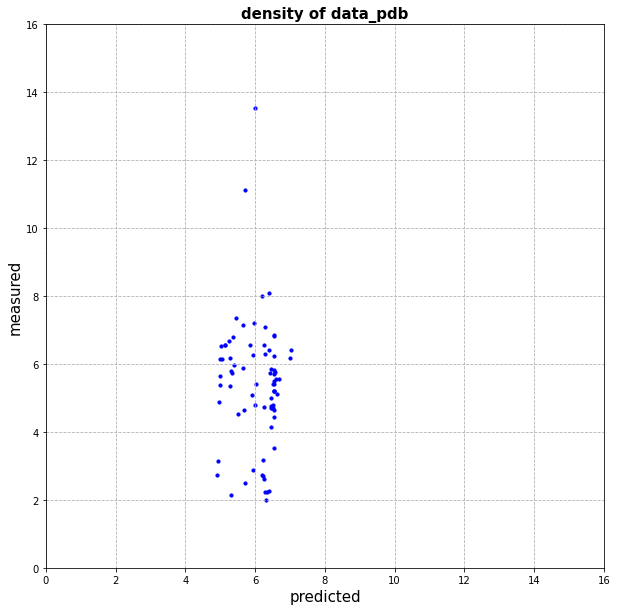

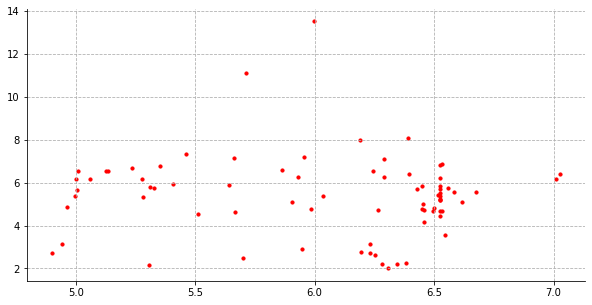

In [42]:
# 1109 test 

import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    #print('total_labels:', total_labels, 'total_preds:',total_preds)
    #plt.figure(figsize=(10, 5))
    #plt.grid(linestyle='--')
    #plt.scatter(total_preds,total_labels, color='black', s=10)
    #plt.scatter(total_preds, color='red', s=10)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='data_pdb'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


# def plot_density(Y, P, fold, dataset):
#     plt.figure(figsize=(10, 5))
#     plt.grid(linestyle='--')
#     ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     plt.scatter(P, Y, color='blue', s=10)
#     plt.title('density of ' + dataset, fontsize=15, fontweight='bold')
#     plt.xlabel('predicted', fontsize=15) #, fontweight='bold')
#     plt.ylabel('measured', fontsize=15) #, fontweight='bold')
#     # plt.xlim(0, 21)
#     # plt.ylim(0, 21)
#     if dataset == 'davis':
#         plt.plot([5, 11], [5, 11], color='black')
#     else:
#         plt.plot([6, 16], [6, 16], color='black')
#     # plt.legend()
#     plt.legend(loc=0, numpoints=1)
#     leg = plt.gca().get_legend()
#     ltext = leg.get_texts()
#     plt.setp(ltext, fontsize=12, fontweight='bold')
#     plt.savefig(os.path.join('results', dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')
    
def plot(Y, P):
    plt.figure(figsize=(10,5))
    plt.grid(linestyle = '--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.scatter(P, color = 'black', s =10)
    plt.scatter(P, Y, color = 'red', s=10)
    

def plot_density(Y, P, fold=0, dataset='kiba'):
    plt.figure(figsize=(10, 10))
    plt.grid(linestyle='--')
    #ax = plt.gca()
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    plt.axis([0, 16, 0, 16])

    plt.scatter(P, Y, color='blue', s=10)
    plt.title('density of ' + dataset, fontsize=15, fontweight='bold')
    plt.xlabel('predicted', fontsize=15)#, fontweight='bold')
    plt.ylabel('measured', fontsize=15)#, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    #if dataset == 'davis':
    #    plt.plot([5, 11], [5, 11], color='black')
    #else:
    #    plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    #plt.legend(loc=0, numpoints=1)
    #leg = plt.gca().get_legend()
    #ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')
    


if __name__ == '__main__':
    #dataset = ['davis', 'kiba'][int(sys.argv[1])]  # dataset selection
    dataset = 'data_pdb'
    model_st = GNNNet.__name__
    print('dataset:', dataset)

    #cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][int(sys.argv[2])]  # gpu selection
    cuda_name = 'cuda:0'
    #print('cuda_name:', cuda_name)

    TEST_BATCH_SIZE = 512
    models_dir = 'models'
    results_dir = 'results'

    device = 'cpu'
    #device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
    model_file_name = 'models/model_' + model_st + '_' + 'davis' + '.model'
    result_file_name = 'results/result_' + model_st + '_' + dataset + '.txt'

    model = GNNNet()
    model.to(device)
    model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
    test_data = create_dataset_for_test(dataset)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    Y, P = predicting(model, device, test_loader)
    calculate_metrics(Y, P, dataset)
    # plot_density(Y, P, fold, dataset)
    fold = 2
    plot_density(Y, P, fold, dataset)
    plot(Y,P)


dataset: data_pdb
GNNNet Loaded
dataset: data_pdb
test entries: 77 effective test entries 77
effective drugs,effective prot: 77 77
Make prediction for 77 samples...
metrics for  data_pdb
cindex: 0.5924744897959183
cindex2 0.5651354130956462
rm2: 0.05247401492158618
mse: 38.42846
pearson 0.229528226689094
data_pdb
rmse:6.199069217832664  mse:38.42846  pearson:0.229528226689094 spearman:0.18876283388984483 ci:0.5924744897959183 rm2:0.05247401492158618


/home/ailon/anaconda3/envs/dgraphdta/lib/python3.6/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.


TypeError: the first argument to axis() must be an interable of the form [xmin, xmax, ymin, ymax]

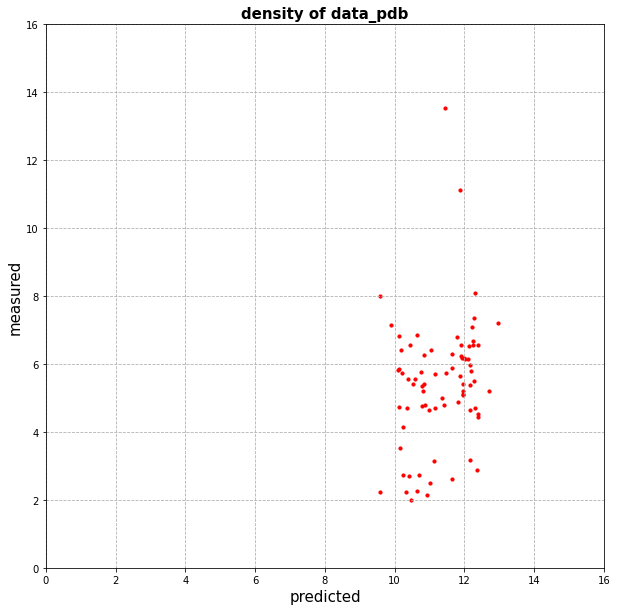

In [48]:
# 1109 test 

import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='data_pdb'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='kiba'):
    plt.figure(figsize=(10, 10))
    plt.grid(linestyle='--')
    #ax = plt.gca()
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    plt.axis([0, 16, 0, 16])

    plt.scatter(P, Y, color='red', s=10)
    plt.title('density of ' + dataset, fontsize=15, fontweight='bold')
    plt.xlabel('predicted', fontsize=15)#, fontweight='bold')
    plt.ylabel('measured', fontsize=15)#, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    #if dataset == 'davis':
    #    plt.plot([5, 11], [5, 11], color='black')
    #else:
    #    plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    #plt.legend(loc=0, numpoints=1)
    #leg = plt.axis(0, 16).get_legend()
    #ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.show
    #plt.savefig(os.path.join('results', dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')
    
    
if __name__ == '__main__':
    #dataset = ['davis', 'kiba'][int(sys.argv[1])]  # dataset selection
    dataset = 'data_pdb'
    model_st = GNNNet.__name__
    print('dataset:', dataset)

    #cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][int(sys.argv[2])]  # gpu selection
    cuda_name = 'cuda:0'
    #print('cuda_name:', cuda_name)

    TEST_BATCH_SIZE = 512
    models_dir = 'models'
    results_dir = 'results'

    device = 'cpu'
    #device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
    model_file_name = 'models/model_' + model_st + '_' + 'kiba' + '.model'
    result_file_name = 'results/result_' + model_st + '_' + dataset + '.txt'

    model = GNNNet()
    model.to(device)
    model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
    test_data = create_dataset_for_test(dataset)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

    Y, P = predicting(model, device, test_loader)
    calculate_metrics(Y, P, dataset)
    # plot_density(Y, P, fold, dataset)
    fold = 3
    plot_density(Y, P, fold, dataset)
